In [1]:
# 导入必要的库
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors

In [2]:
df_2022 = pd.read_csv('user_2022.csv')

In [3]:
df_2022.head()

,user_id,order_no,paid_cash,create_date
0,648836,202201120847929,99.0,2022/1/12
1,648836,202301020055201,99.0,2023/1/2
2,648836,202207280985024,63.0,2022/7/28
3,648851,202306300144350,9.9,2023/6/30
4,648851,202201090845442,99.0,2022/1/9


In [4]:
df_2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10283 entries, 0 to 10282
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      10283 non-null  int64  
 1   order_no     10283 non-null  int64  
 2   paid_cash    10283 non-null  float64
 3   create_date  10283 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 321.5+ KB


In [5]:
# 转化日期

df_2022['create_date'] = pd.to_datetime(df_2022['create_date'])

#计算最大日期为今天
current_date = df_2022['create_date'].max() + pd.to_timedelta(1, 'D')

In [6]:
# 计算 RFM 值

rfm = df_2022.groupby('user_id').agg({
    'create_date': lambda x: (current_date - x.max()).days,
    'order_no': 'count',
    'paid_cash': 'sum'
}).rename(columns={
    'create_date': 'Recency',
    'order_no': 'Frequency',
    'paid_cash': 'Monetary'
    
})

In [7]:
rfm.head(5)

,Recency,Frequency,Monetary
user_id,,,
648836,248,3,261.0
648851,69,3,398.9
648857,533,1,99.0
648860,534,1,99.0
648873,216,4,260.0


In [8]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4447 entries, 648836 to 731231
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    4447 non-null   int64  
 1   Frequency  4447 non-null   int64  
 2   Monetary   4447 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 139.0 KB


In [20]:
# 数据预处理
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# 使用优化的参数进行聚类
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=80,
    min_samples=5, 
    metric='euclidean', 
    cluster_selection_epsilon=0.15, 
    alpha=3.5, 
    cluster_selection_method='eom', 
    algorithm='best')
clusterer.fit(rfm_scaled)
rfm['Cluster'] = pd.Series(clusterer.labels_, index=rfm.index)

# 查看结果
print(rfm['Cluster'].value_counts())

 5    2358
 4     845
-1     460
 3     332
 0     211
 2     148
 1      93
Name: Cluster, dtype: int64


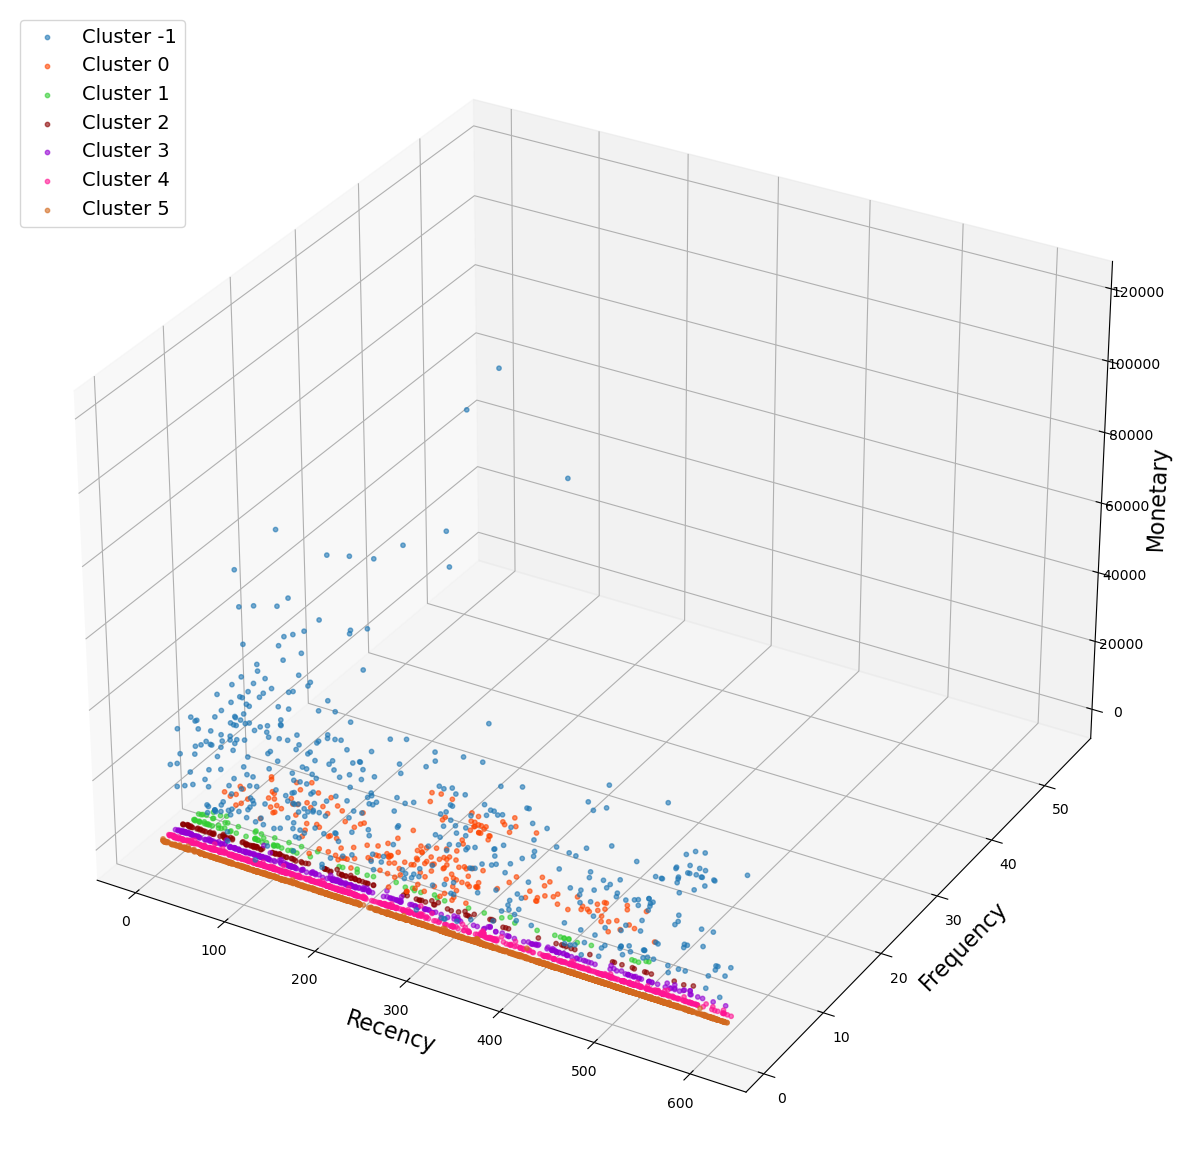

In [22]:
# 使用更为鲜明的颜色组合
colors = [
    "#1f77b4", "#ff4500", "#32cd32", "#8b0000", "#9400d3",
    "#ff1493", "#d2691e", "#00ced1", "#ff69b4", "#ffd700",
    "#adff2f", "#ffa500", "#4b0082"
]

# 进一步增加透明度
alpha_value = 0.6

# 保持点的大小
sizes = {cluster: 10 for cluster in rfm['Cluster'].unique()}

fig = plt.figure(figsize=(20, 15))
dx = fig.add_subplot(111, projection='3d')

for i, label in enumerate(sorted(rfm['Cluster'].unique())):
    dx.scatter(rfm[rfm.Cluster == label].Recency,
               rfm[rfm.Cluster == label].Frequency,
               rfm[rfm.Cluster == label].Monetary,
               c=[colors[i]],
               label='Cluster ' + str(label),
               s=sizes[label], alpha=alpha_value)

dx.set_xlabel('Recency', fontsize=16)
dx.set_ylabel('Frequency', fontsize=16)
dx.set_zlabel('Monetary', fontsize=16)
dx.legend(fontsize=14, loc='upper left')
dx.grid(True)  # 保持网格
plt.show()

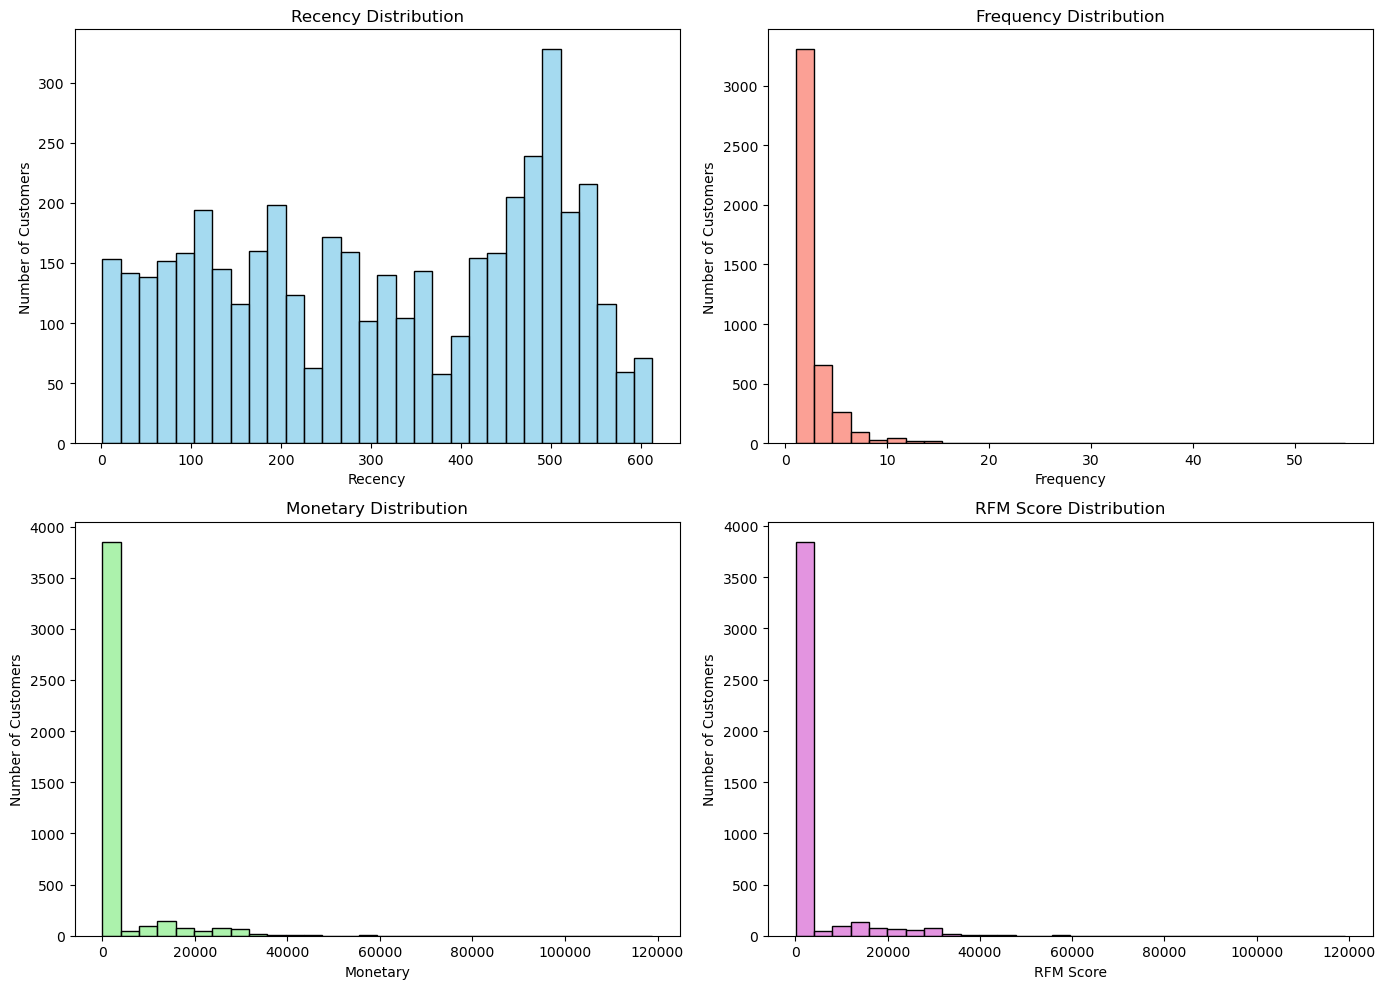

In [23]:
# 创建图形
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Recency分布图
sns.histplot(rfm['Recency'], kde=False, ax=ax[0, 0], bins=30, color='skyblue')
ax[0, 0].set_title('Recency Distribution')
ax[0, 0].set_xlabel('Recency')
ax[0, 0].set_ylabel('Number of Customers')

# Frequency分布图
sns.histplot(rfm['Frequency'], kde=False, ax=ax[0, 1], bins=30, color='salmon')
ax[0, 1].set_title('Frequency Distribution')
ax[0, 1].set_xlabel('Frequency')
ax[0, 1].set_ylabel('Number of Customers')

# Monetary分布图
sns.histplot(rfm['Monetary'], kde=False, ax=ax[1, 0], bins=30, color='lightgreen')
ax[1, 0].set_title('Monetary Distribution')
ax[1, 0].set_xlabel('Monetary')
ax[1, 0].set_ylabel('Number of Customers')

# RFM得分分布图 (需要计算RFM得分)
rfm['RFM_Score'] = rfm['Recency'] + rfm['Frequency'] + rfm['Monetary']
sns.histplot(rfm['RFM_Score'], kde=False, ax=ax[1, 1], bins=30, color='orchid')
ax[1, 1].set_title('RFM Score Distribution')
ax[1, 1].set_xlabel('RFM Score')
ax[1, 1].set_ylabel('Number of Customers')

plt.tight_layout()
plt.show()

In [24]:
# 获取总金额最大的 TOP50 数据
top_50_data = rfm.sort_values(by='Monetary', ascending=False).head(50)
top_50_data


,Recency,Frequency,Monetary,Cluster,RFM_Score
user_id,,,,,
649441,395,9,118840.00,-1,119244.00
682396,66,11,78140.00,-1,78217.00
650133,3,13,59306.90,-1,59322.90
655156,10,55,58568.41,-1,58633.41
680125,20,48,56665.01,-1,56733.01
718383,65,11,56644.81,-1,56720.81
657226,22,11,53210.90,-1,53243.90
668816,136,15,49701.90,-1,49852.90
688803,16,14,48589.92,-1,48619.92


In [33]:
filtered_rfm = rfm[rfm['Monetary'] <= 40000].copy()

In [34]:
filtered_rfm.head(5)

,Recency,Frequency,Monetary,Cluster,RFM_Score
user_id,,,,,
648836,248,3,261.0,3,512.0
648851,69,3,398.9,3,470.9
648857,533,1,99.0,5,633.0
648860,534,1,99.0,5,634.0
648873,216,4,260.0,2,480.0


In [35]:
# 数据预处理
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(filtered_rfm[['Recency', 'Frequency', 'Monetary']])

# 使用优化的参数进行聚类
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=80,
    min_samples=2, 
    metric='manhattan', 
    cluster_selection_epsilon=0.2, 
    alpha=1.5, 
    cluster_selection_method='eom', 
    algorithm='best')
clusterer.fit(rfm_scaled)
filtered_rfm['Cluster'] = pd.Series(clusterer.labels_, index=filtered_rfm.index)

# 查看结果
print(filtered_rfm['Cluster'].value_counts())

 5    2363
 4     846
 3     334
 0     316
-1     314
 2     149
 1     105
Name: Cluster, dtype: int64


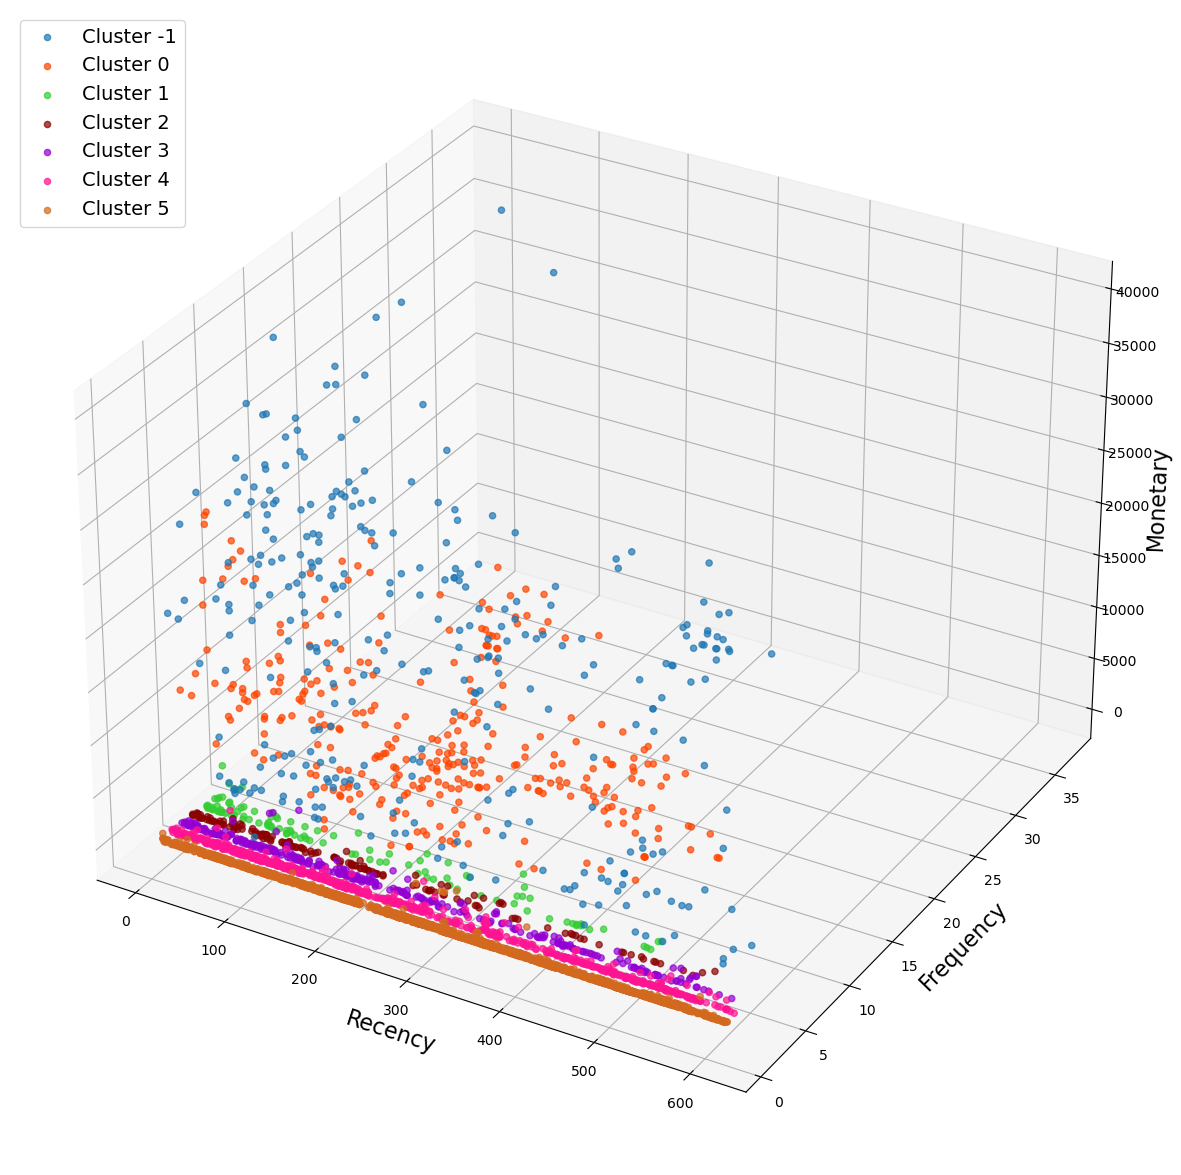

In [36]:
# 使用更为鲜明的颜色组合
colors = [
    "#1f77b4", "#ff4500", "#32cd32", "#8b0000", "#9400d3",
    "#ff1493", "#d2691e", "#00ced1", "#ff69b4", "#ffd700",
    "#adff2f", "#ffa500", "#4b0082"
]

# 进一步增加透明度
alpha_value = 0.7

# 保持点的大小
sizes = {cluster: 20 for cluster in filtered_rfm['Cluster'].unique()}

fig = plt.figure(figsize=(20, 15))
dx = fig.add_subplot(111, projection='3d')

for i, label in enumerate(sorted(filtered_rfm['Cluster'].unique())):
    dx.scatter(filtered_rfm[filtered_rfm.Cluster == label].Recency,
               filtered_rfm[filtered_rfm.Cluster == label].Frequency,
               filtered_rfm[filtered_rfm.Cluster == label].Monetary,
               c=[colors[i]],
               label='Cluster ' + str(label),
               s=sizes[label], alpha=alpha_value)

dx.set_xlabel('Recency', fontsize=16)
dx.set_ylabel('Frequency', fontsize=16)
dx.set_zlabel('Monetary', fontsize=16)
dx.legend(fontsize=14, loc='upper left')
dx.grid(True)  # 保持网格
plt.show()

In [37]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 复制筛选后的数据，避免直接对原数据进行修改
filtered_rfm = rfm[rfm['Monetary'] <= 40000].copy()

# Step 1: Data preprocessing 
rfm_values = filtered_rfm[['Recency', 'Frequency', 'Monetary']].values
rfm_scaled_values = scaler.transform(rfm_values)

# Step 2: Run K-means clustering
k = 5 # 此处是为了简化演示处理，便临时取值为5
kmeans = KMeans(n_clusters=k, random_state=42)
filtered_rfm['KMeans_Cluster'] = kmeans.fit_predict(rfm_scaled_values)

# Step 3: Evaluate the clusters
silhouette_avg = silhouette_score(rfm_scaled_values, filtered_rfm['KMeans_Cluster'])

# Cluster counts and silhouette score
cluster_counts = filtered_rfm['KMeans_Cluster'].value_counts()
cluster_counts, silhouette_avg

C:\Users\EDY\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


(0    1998
 4    1653
 1     372
 2     340
 3      64
 Name: KMeans_Cluster, dtype: int64,
 0.522214084151274)

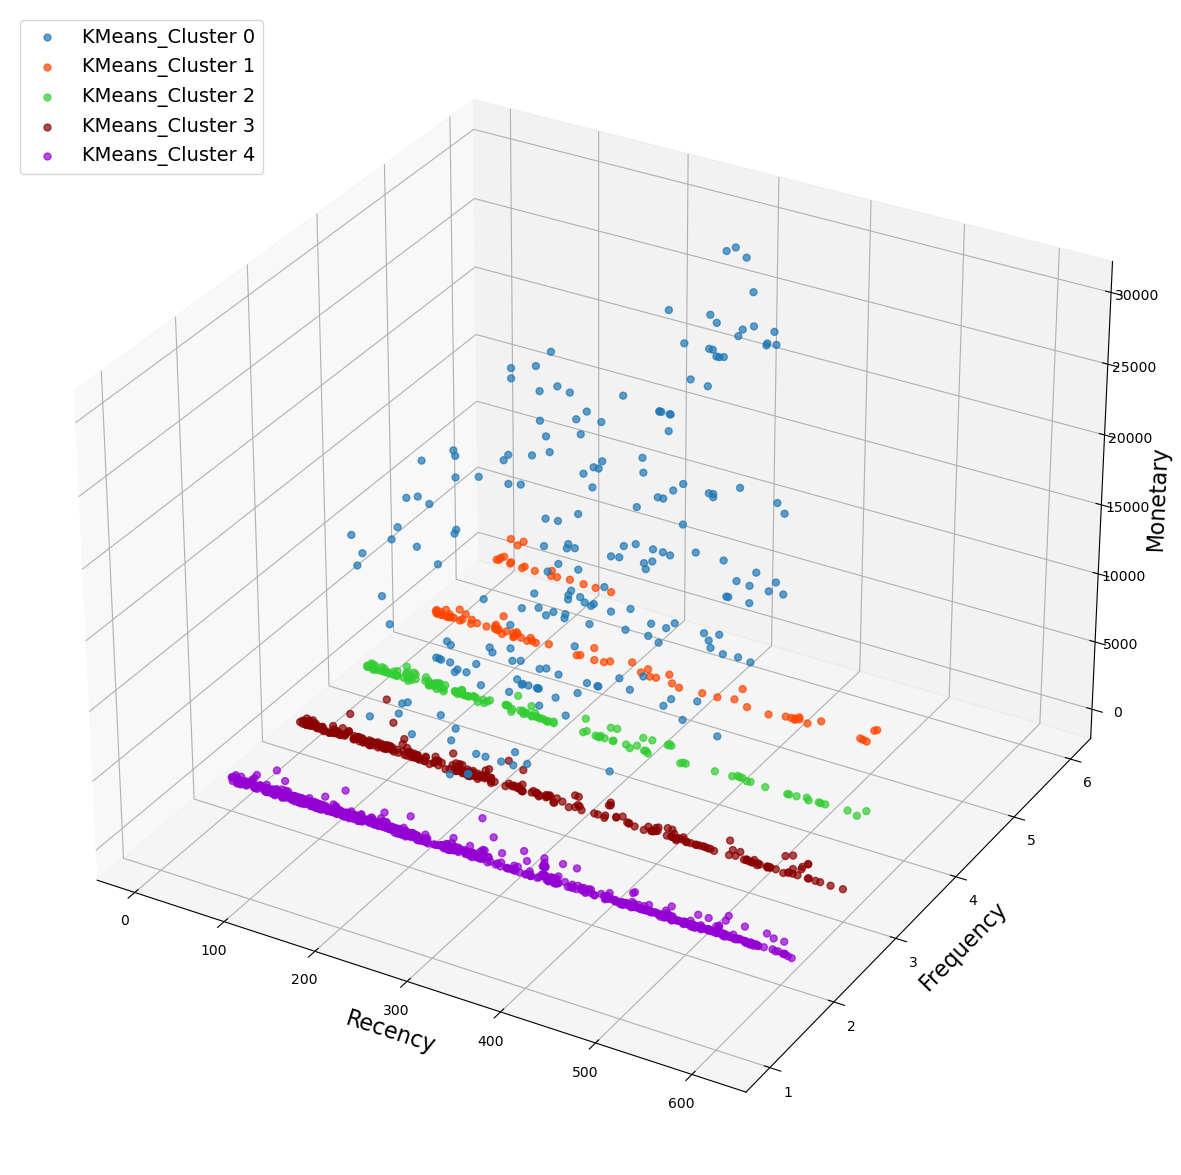

In [39]:
# 对KMeans结果进行3D可视化处理

# 使用更为鲜明的颜色组合
colors = [
    "#1f77b4", "#ff4500", "#32cd32", "#8b0000", "#9400d3",
    "#ff1493", "#d2691e", "#00ced1", "#ff69b4", "#ffd700",
    "#adff2f", "#ffa500", "#4b0082"
]

# 进一步增加透明度
alpha_value = 0.7

# 保持点的大小
sizes = {cluster: 25 for cluster in filtered_rfm['KMeans_Cluster'].unique()}

fig = plt.figure(figsize=(20, 15))
dx = fig.add_subplot(111, projection='3d')

for i, label in enumerate(sorted(filtered_rfm['KMeans_Cluster'].unique())):
    dx.scatter(filtered_rfm[filtered_rfm.Cluster == label].Recency,
               filtered_rfm[filtered_rfm.Cluster == label].Frequency,
               filtered_rfm[filtered_rfm.Cluster == label].Monetary,
               c=[colors[i]],
               label='KMeans_Cluster ' + str(label),
               s=sizes[label], alpha=alpha_value)

dx.set_xlabel('Recency', fontsize=16)
dx.set_ylabel('Frequency', fontsize=16)
dx.set_zlabel('Monetary', fontsize=16)
dx.legend(fontsize=14, loc='upper left')
dx.grid(True)  # 保持网格
plt.show()

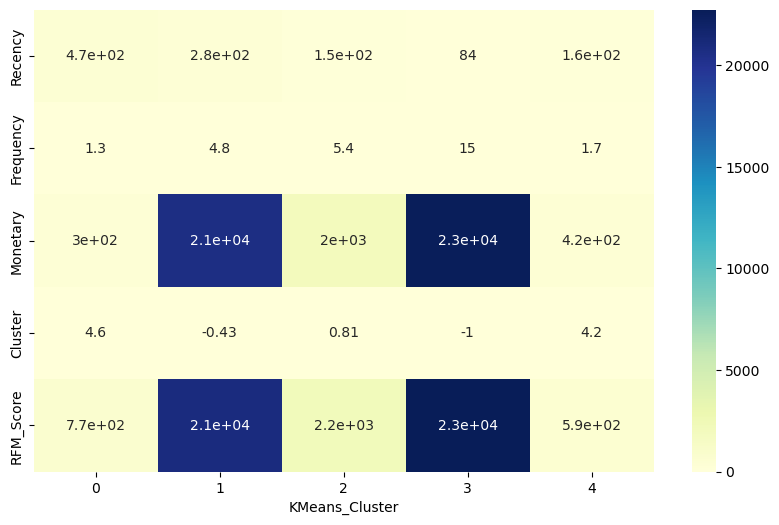

In [29]:
# 绘制热力图

import seaborn as sns
import pandas as pd

# Calculate mean values for each cluster
cluster_means = filtered_rfm.groupby('KMeans_Cluster').mean()

# Plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(cluster_means.transpose(), cmap='YlGnBu', annot=True)
plt.show()

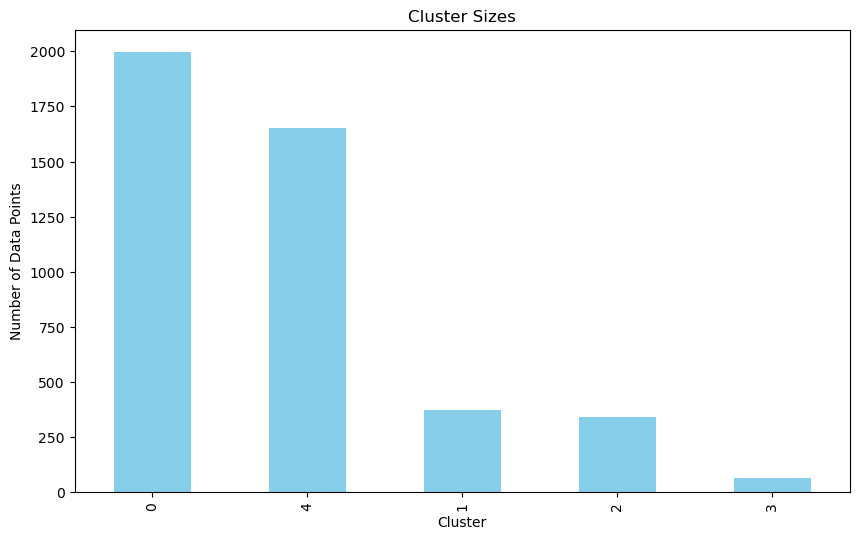

In [30]:
# 簇的大小和分布

cluster_counts = filtered_rfm['KMeans_Cluster'].value_counts()

# Plot
plt.figure(figsize=(10,6))
cluster_counts.plot(kind='bar', color='skyblue')
plt.title('Cluster Sizes')
plt.xlabel('Cluster')
plt.ylabel('Number of Data Points')
plt.show()

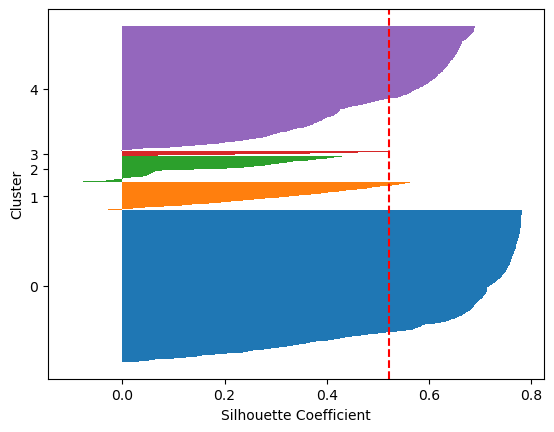

In [32]:
# 轮廓图
import numpy as np
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

# Calculate silhouette values
silhouette_vals = silhouette_samples(rfm_scaled_values, filtered_rfm['KMeans_Cluster'])

# Plot
y_lower, y_upper = 0, 0
yticks = []
for i, cluster in enumerate(np.unique(filtered_rfm['KMeans_Cluster'])):
    cluster_silhouette_vals = silhouette_vals[filtered_rfm['KMeans_Cluster'] == cluster]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, height=1)
    yticks.append((y_lower + y_upper) / 2)
    y_lower += len(cluster_silhouette_vals)
    
plt.axvline(np.mean(silhouette_vals), color="red", linestyle="--") 
plt.yticks(yticks, labels=np.unique(filtered_rfm['KMeans_Cluster']))
plt.ylabel('Cluster')
plt.xlabel('Silhouette Coefficient')
plt.show()

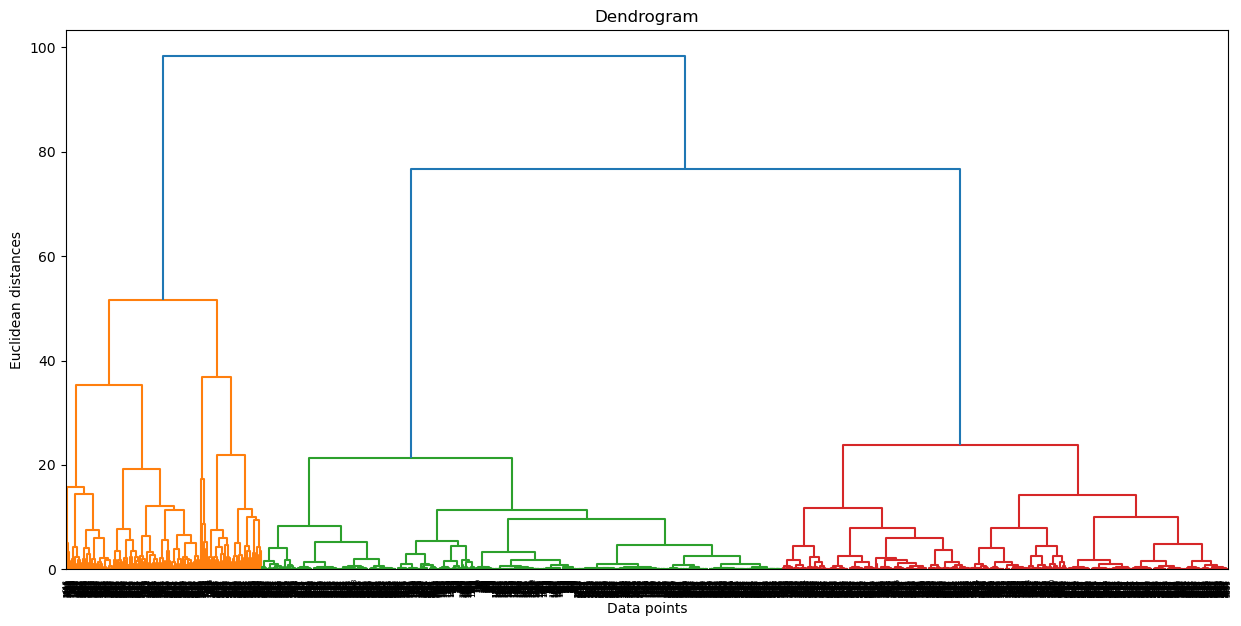

In [33]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

# 使用层次聚类方法进行聚类
linkage_matrix = sch.linkage(rfm_scaled_values, method='ward')  # 'ward' 是一种链接方法

# 绘制树形图
plt.figure(figsize=(15, 7))
dendrogram = sch.dendrogram(linkage_matrix)
plt.title('Dendrogram')
plt.xlabel('Data points')
plt.ylabel('Euclidean distances')
plt.show()

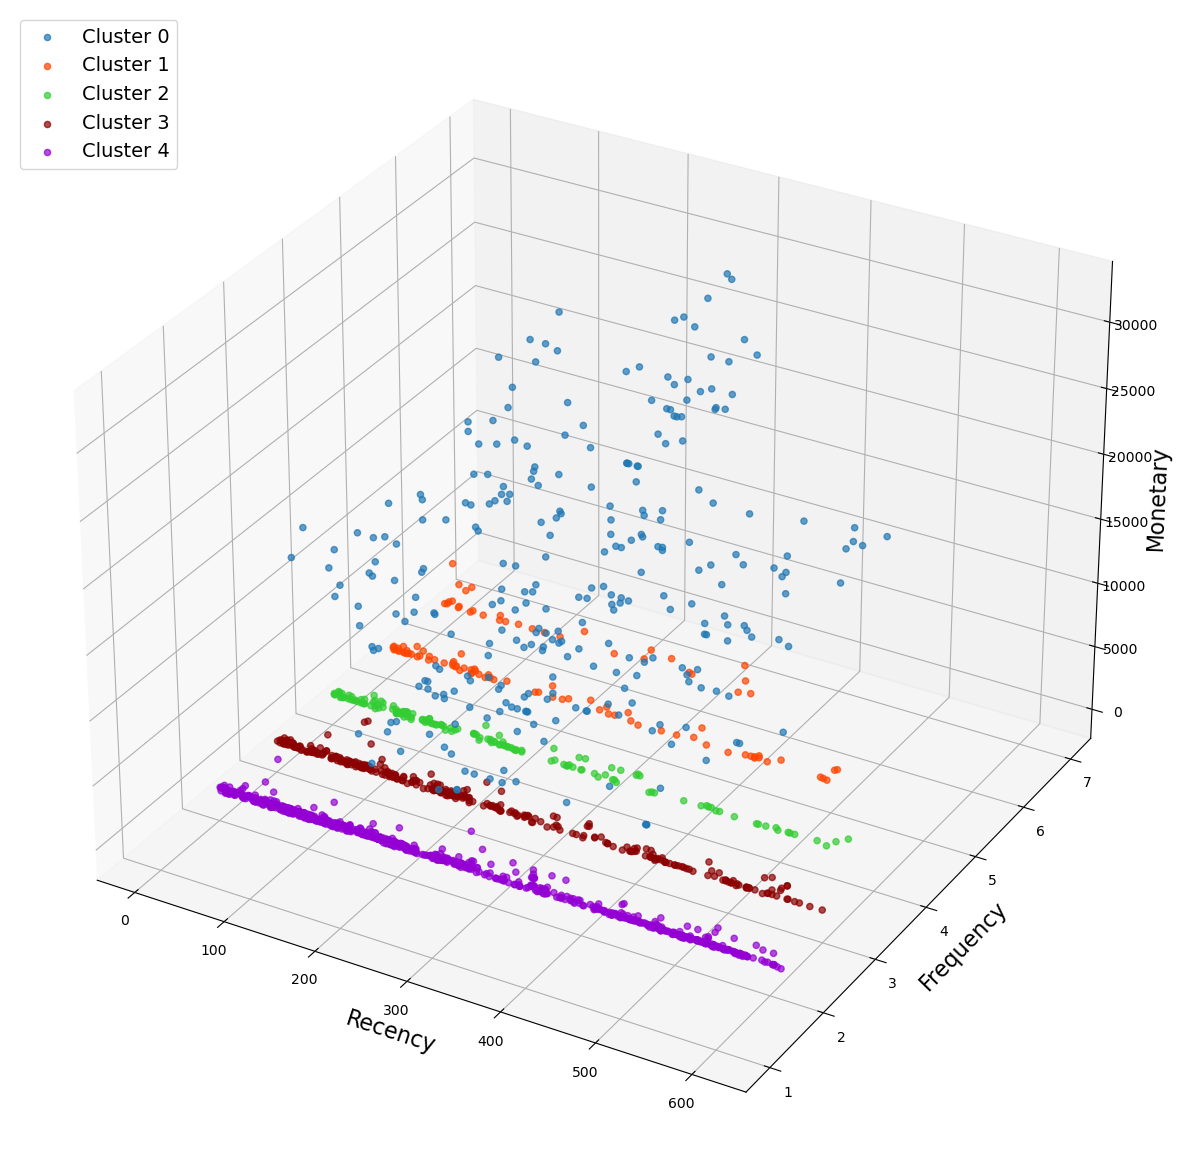

In [34]:
# 使用更为鲜明的颜色组合
colors = [
    "#1f77b4", "#ff4500", "#32cd32", "#8b0000", "#9400d3",
    "#ff1493", "#d2691e", "#00ced1", "#ff69b4", "#ffd700",
    "#adff2f", "#ffa500", "#4b0082"
]

# 进一步增加透明度
alpha_value = 0.7

# 保持点的大小
sizes = {cluster: 20 for cluster in filtered_rfm['KMeans_Cluster'].unique()}

fig = plt.figure(figsize=(20, 15))
dx = fig.add_subplot(111, projection='3d')

for i, label in enumerate(sorted(filtered_rfm['KMeans_Cluster'].unique())):
    dx.scatter(filtered_rfm[filtered_rfm.Cluster == label].Recency,
               filtered_rfm[filtered_rfm.Cluster == label].Frequency,
               filtered_rfm[filtered_rfm.Cluster == label].Monetary,
               c=[colors[i]],
               label='Cluster ' + str(label),
               s=sizes[label], alpha=alpha_value)

dx.set_xlabel('Recency', fontsize=16)
dx.set_ylabel('Frequency', fontsize=16)
dx.set_zlabel('Monetary', fontsize=16)
dx.legend(fontsize=14, loc='upper left')
dx.grid(True)  # 保持网格
plt.show()

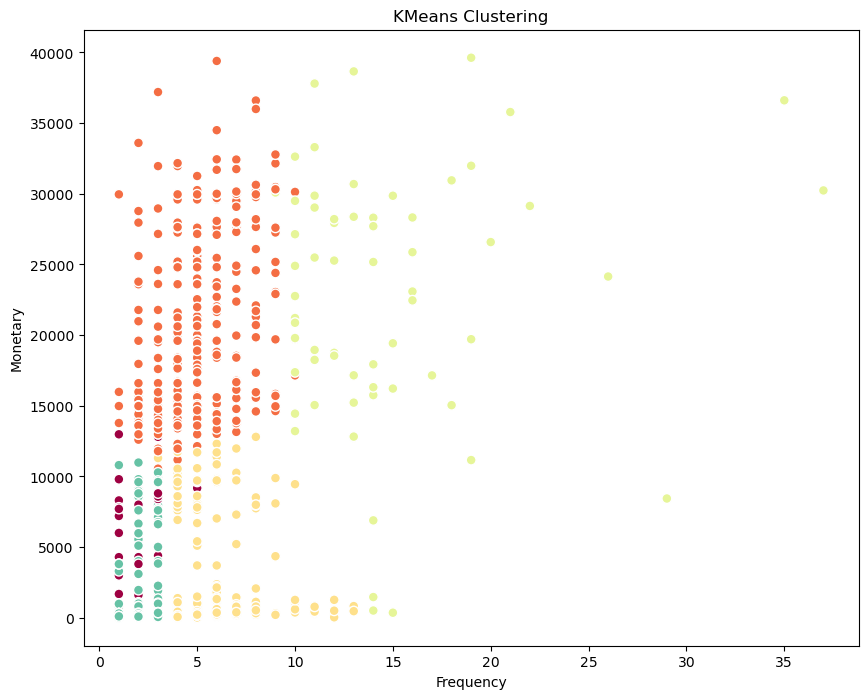

In [36]:
import matplotlib.pyplot as plt

# 获取数据点的特征值
x = filtered_rfm['Frequency']
y = filtered_rfm['Monetary']

# 根据KMeans的结果为每个簇分配颜色
colors = plt.cm.Spectral(filtered_rfm['KMeans_Cluster'].astype(float) / k)  # 假设 k 是您的簇数量

# 绘制散点图
plt.figure(figsize=(10, 8))
plt.scatter(x, y, c=colors, marker='o', edgecolor='w', s=50)
plt.title('KMeans Clustering')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()


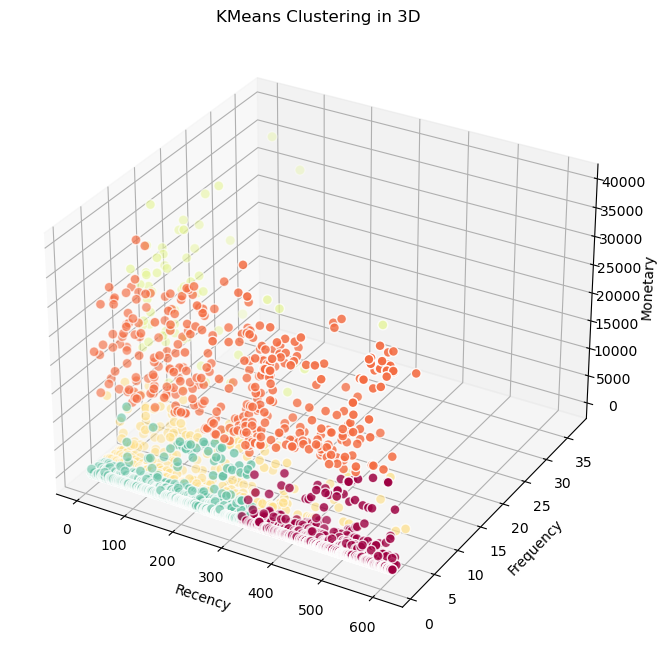

In [37]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 获取数据点的特征值
x = filtered_rfm['Recency']
y = filtered_rfm['Frequency']
z = filtered_rfm['Monetary']

# 创建一个新的图形
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 根据KMeans的结果为每个簇分配颜色
colors = plt.cm.Spectral(filtered_rfm['KMeans_Cluster'].astype(float) / k)  # 假设 k 是您的簇数量

# 在3D空间中绘制散点图
ax.scatter(x, y, z, c=colors, marker='o', edgecolor='w', s=50)

ax.set_title('KMeans Clustering in 3D')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.show()
